#### Hypothesis: amount of loan lent per month is a time series. We try to predict total amount that will be lent on a month

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [90]:
import matplotlib.pyplot as plt
import pylab

In [67]:
df = pd.read_csv("Master_Loan_Summary.csv")

/Users/naimulhoque/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
df = df[["origination_date","amount_borrowed","data_source"]]

In [69]:
df.head()

,origination_date,amount_borrowed,data_source
0,2013-12-01T00:00,27050.0,Lending Club
1,2013-12-01T00:00,4800.0,Lending Club
2,2013-12-01T00:00,12000.0,Lending Club
3,2013-12-01T00:00,12000.0,Lending Club
4,2013-12-01T00:00,12000.0,Lending Club


In [70]:
def make_feature(df):
    
    date = [] 
    #months = []
    
    for index, row in df.iterrows():
                
        #Calculate year and month
        year,month,day = row['origination_date'].split('-')     
        
        date.append(year+month)
        #months.append(month)
                 
        
    df["date"] = date
    #df["month"] = months
    
    return df

In [71]:
df = make_feature(df)

In [72]:
df.head()

,origination_date,amount_borrowed,data_source,date
0,2013-12-01T00:00,27050.0,Lending Club,201312
1,2013-12-01T00:00,4800.0,Lending Club,201312
2,2013-12-01T00:00,12000.0,Lending Club,201312
3,2013-12-01T00:00,12000.0,Lending Club,201312
4,2013-12-01T00:00,12000.0,Lending Club,201312


In [73]:
print(df["date"].unique())

['201312' '201311' '201310' '201309' '201308' '201307' '201306' '201305'
 '201304' '201303' '201302' '201301' '201212' '201211' '201210' '201209'
 '201208' '201207' '201206' '201205' '201204' '201203' '201202' '201201'
 '201412' '201411' '201410' '201409' '201408' '201407' '201406' '201405'
 '201404' '201403' '201402' '201401' '201512' '201511' '201510' '201509'
 '201508' '201507' '201506' '201505' '201504' '201503' '201502' '201501'
 '201603' '201602' '201601' '201606' '201605' '201604' '201609' '201608'
 '201607' '201612' '201611' '201610' '201703' '201702' '201701' '201706'
 '201705' '201704' '201709' '201708' '201707' '201712' '201711' '201710'
 '201803' '201802' '201801' '201806' '201805' '201804']


In [74]:
null_count = df.isna().sum()
null_count

origination_date    0
amount_borrowed     0
data_source         0
date                0
dtype: int64

In [75]:
grouped = df.groupby(['date'])['amount_borrowed'].sum().reset_index()

In [78]:
grouped.head()

,date,amount_borrowed
0,201201,34000575.0
1,201202,36058175.0
2,201203,39536300.0
3,201204,42051125.0
4,201205,45090825.0


In [122]:
x = grouped.values

In [123]:
y = x[:,0]

In [124]:
x = x[:,1]

In [134]:
def plot_data(r,s,y_pred,test,y_label):
    
    plot_x = []
    for i in range(r,r+s):
        plot_x.append(i)
        
    plt.plot(plot_x,test,label="original")
    plt.plot(plot_x,y_pred,label=y_label)
    plt.xlabel('Time')
    plt.ylabel('Loan Borrowed per Month')
    pylab.legend(loc='upper left')   
    plt.show()

In [137]:
def EWMA(alpha):
    
    training = x[:25]
    test = x[25:]
    
    r= len(training)
    s = len(test)
    
    error = []
    y = []
    for i in range(r,r+s):
        base = 0
        j = i-1
        k = 0
        while(j >= 0):
            base = base+ (x[j]*((1-alpha)**k))
            j = j-1 
            k = k+1

        y_pred = alpha*base
        y.append(y_pred)
        
        error.append((abs(y_pred-x[i])/x[i])*100)
        
    plot_data(r,s,y,test,"EWMA("+str(alpha)+")")
    
    return sum(error)/len(error)

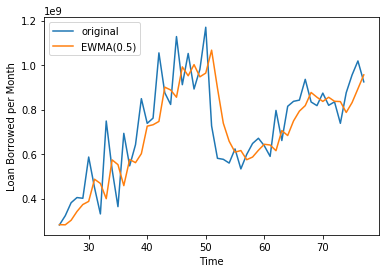

14.910090672916523


In [138]:
error = EWMA(0.5)
print(error)

In [111]:
def train_lr(p,length):
    #print("jhjd")
    training = []
    label = []
    
    for i in range(length):
        if(i+p < length):
            #print("ghttt")
            training.append([1])
            training[i] = training[i]+list(x[i:i+p])
            #training.append(x[i:i+144])
            label.append(x[i+p])

        else:
            break
            
    #print(len(label))
    beta=np.matmul(np.linalg.inv(np.matmul(np.transpose(training),training)),np.matmul(np.transpose(training),label))
    
    return beta

In [112]:
def AR(p):
    
    training = x[:25]
    test = x[25:]
    
    r= len(training)
    s = len(test)
    
    error = []
    y = []
    for i in range(r,r+s):
        
        #print(i)
        testx = [1]
        temp = x[i-p:i]
        testx = testx + list(temp)
        #print("ggg")
        beta = train_lr(p,i)
        y_pred=np.matmul(testx,beta)
        y.append(y_pred)
        
        error.append((abs(y_pred-x[i])/x[i])*100)
        
    plot_data(r,s,y,test,"AR("+str(p)+")")
    
    return sum(error)/len(error)

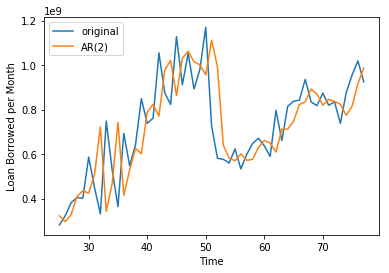

17.76334419853286

In [115]:
AR(2)

In [116]:
def Seasonal(S):
    
    training = x[:25]
    test = x[25:]
    
    r= len(training)
    s = len(test)
    
    error = []
    y = []
    for i in range(r,r+s):
      
        y_pred = x[i-S]
        y.append(y_pred)

        error.append((abs(y_pred-x[i])/x[i])*100)
        
    plot_data(r,s,y,test,"Seasonal("+str(S)+")")
    
    return sum(error)/len(error)

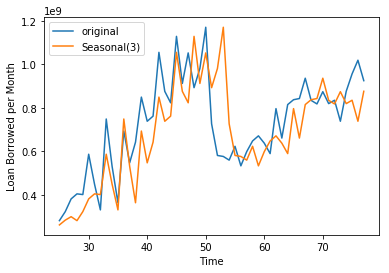

16.835573625162837

In [121]:
Seasonal(3)